In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os.path
import pickle
%matplotlib inline

def threshold_image(img):
  # RGB color thresholding
  rgb_low = np.array([200, 200, 10])
  rgb_high = np.array([255]*3)
  rgb_binary = cv2.inRange(img, rgb_low, rgb_high).astype(np.bool)
  
  # S channel thresholding
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
  s_channel = hls[:,:, 2]
  s_channel_binary = np.zeros_like(s_channel)
  s_channel_binary[(s_channel >= 150) & (s_channel <= 200)] = 1
  s_channel_binary = s_channel_binary.astype(np.bool)
  
  # Gradient thresholding
  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gradient_binary = gradient_threshold(gray)
  
  combined_color = np.zeros_like(img)
  combined_color[rgb_binary, 0] = 255
  combined_color[s_channel_binary, 1] = 255
  combined_color[gradient_binary, 2] = 255

  combined_binary = np.zeros_like(gray)
  combined_binary[rgb_binary | s_channel_binary | gradient_binary] = 255
  return combined_color, combined_binary


def gradient_threshold(gray):
  kernel_size = 5
  blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
  sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
  sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
  sobel_xy = np.sqrt(sobel_x**2 + sobel_y**2)
  sobel_xy *= 255.0 / np.max(sobel_xy)
  sobel_x *= 255.0 / np.max(sobel_x)
  binary = np.zeros_like(gray)
  binary[(sobel_xy >= 40) & (sobel_xy < 100)] = 1
  return binary.astype(np.bool)

def edge_threshold(gray):
  kernel_size = 5
  blur_gray = cv2.GaussianBlur(gray, (kernel_size, kernel_size), 0)
  binary = cv2.Canny(blur_gray, 50, 100).astype(np.bool)
  return binary
  
def get_perspective_transform(w=1280, h=720):
  """Get perspective transform matrices."""
  src = np.float32([[590, 458], [700, 458], [1156, 714], [267, 714]])
  dst = np.float32([[w*0.25, h*0.2], [w*0.75, h*0.2], [w*0.75, h*0.99], [w*0.25, h*0.99]])
  M = cv2.getPerspectiveTransform(src, dst)
  Minv = cv2.getPerspectiveTransform(dst, src)
  return M, Minv

def find_lane_pixels_by_sliding_windows(binary_warped, viz_img=None):
  """Find lane pixels by sliding windows. Copied from Udacity."""
  # Take a histogram of the bottom half of the image
  histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
  # Find the peak of the left and right halves of the histogram
  # These will be the starting point for the left and right lines
  midpoint = np.int(histogram.shape[0]//2)
  leftx_base = np.argmax(histogram[:midpoint])
  rightx_base = np.argmax(histogram[midpoint:]) + midpoint

  # HYPERPARAMETERS
  # Choose the number of sliding windows
  nwindows = 9
  # Set the width of the windows +/- margin
  margin = 100
  # Set minimum number of pixels found to recenter window
  minpix = 50

  # Set height of windows - based on nwindows above and image shape
  window_height = np.int(binary_warped.shape[0]//nwindows)
  # Identify the x and y positions of all nonzero pixels in the image
  nonzero = binary_warped.nonzero()
  nonzeroy = np.array(nonzero[0])
  nonzerox = np.array(nonzero[1])
  # Current positions to be updated later for each window in nwindows
  leftx_current = leftx_base
  rightx_current = rightx_base

  # Create empty lists to receive left and right lane pixel indices
  left_lane_inds = []
  right_lane_inds = []

  # Step through the windows one by one
  for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin

    # Draw the windows on the visualization image
    if viz_img is not None:
      cv2.rectangle(viz_img, (win_xleft_low,win_y_low),
                    (win_xleft_high,win_y_high), (0,255,0), 2)
      cv2.rectangle(viz_img, (win_xright_low,win_y_low),
                    (win_xright_high,win_y_high), (0,255,0), 2)

    # Identify the nonzero pixels in x and y within the window #
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                      (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) &
                       (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)

    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
      leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:
      rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

  # Concatenate the arrays of indices (previously was a list of lists of pixels)
  try:
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
  except ValueError:
    # Avoids an error if the above is not implemented fully
    pass

  # Extract left and right line pixel positions
  leftx = nonzerox[left_lane_inds]
  lefty = nonzeroy[left_lane_inds]
  rightx = nonzerox[right_lane_inds]
  righty = nonzeroy[right_lane_inds]

  # Visualize lane pixels
  if viz_img is not None:
    viz_img[lefty, leftx] = [255, 0, 0]
    viz_img[righty, rightx] = [0, 0, 255]
  return leftx, lefty, rightx, righty

def search_by_prev_poly(binary_warped, left_fit, right_fit, viz_img=None):
  """Search lane pixels around previous poly lines."""
  # HYPERPARAMETER
  # Choose the width of the margin around the previous polynomial to search
  # The quiz grader expects 100 here, but feel free to tune on your own!
  margin = 100

  # Grab activated pixels
  nonzero = binary_warped.nonzero()
  nonzeroy = np.array(nonzero[0])
  nonzerox = np.array(nonzero[1])

  ### TO-DO: Set the area of search based on activated x-values ###
  ### within the +/- margin of our polynomial function ###
  ### Hint: consider the window areas for the similarly named variables ###
  ### in the previous quiz, but change the windows to our new search area ###
  left_polyx = left_fit[0] * (nonzeroy ** 2) + left_fit[1] * nonzeroy + left_fit[2]
  left_lane_inds = np.abs(nonzerox - left_polyx) < margin 
  right_polyx = right_fit[0] * (nonzeroy ** 2) + right_fit[1] * nonzeroy + right_fit[2]
  right_lane_inds = np.abs(nonzerox - right_polyx) < margin

  # Again, extract left and right line pixel positions
  leftx = nonzerox[left_lane_inds]
  lefty = nonzeroy[left_lane_inds]
  rightx = nonzerox[right_lane_inds]
  righty = nonzeroy[right_lane_inds]

  # Fit new polynomials

  ## Visualization ##
  # Color in left and right line pixels
  if viz_img is not None:
    
    left_fitx, right_fitx, ploty = gen_poly(binary_warped.shape, left_fit, right_fit)
    # Generate a polygon to illustrate the search area
    fill_poly(viz_img, left_fitx - margin, left_fitx + margin, ploty, (0, 255, 0))
    fill_poly(viz_img, right_fitx - margin, right_fitx + margin, ploty, (0, 255, 0))

    # Draw polynomial lines onto the image
    #viz_img[ploty, left_fitx] = [255, 255, 0]
    #viz_img[ploty, right_fitx] = [255, 255, 0]

    viz_img[lefty, leftx] = [255, 0, 0]
    viz_img[righty, rightx] = [0, 0, 255]

  return leftx, lefty, rightx, righty

def gen_poly(img_shape, left_fit, right_fit):
  """Generate x and y values given polynomial lines."""
  ploty = np.arange(0, img_shape[0])
  # ploty = np.linspace(0, img_shape[0]-1, img_shape[0] )
  try:
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
  except TypeError:
    # Avoids an error if `left` and `right_fit` are still none or incorrect
    print('The function failed to fit a line!')
    left_fitx = 1*ploty**2 + 1*ploty
    right_fitx = 1*ploty**2 + 1*ploty
  left_fitx = left_fitx.astype(np.int32)
  right_fitx = right_fitx.astype(np.int32)
  left_fitx = np.clip(left_fitx, 0, img_shape[1] - 1)
  right_fitx = np.clip(right_fitx, 0, img_shape[1] - 1)
  return left_fitx, right_fitx, ploty

def fit_poly(img_shape, leftx, lefty, rightx, righty, viz_img=None):
  """Fit polynomial lines given lane line pixels."""

  # Fit a second order polynomial to each using `np.polyfit`
  left_fit = np.polyfit(lefty, leftx, 2)
  right_fit = np.polyfit(righty, rightx, 2)

  left_fitx, right_fitx, ploty = gen_poly(img_shape, left_fit, right_fit)

  # Visualize the left and right polynomials on the lane lines
  if viz_img is not None:
    viz_img[ploty, left_fitx] = [255, 255, 0]
    viz_img[ploty, right_fitx] = [255, 255, 0]
    #draw_poly(viz_img, left_fitx, ploty, (255, 255, 0))
    #draw_poly(viz_img, right_fitx, ploty, (255, 255, 0))
  #return left_fitx, left_fit, right_fitx, right_fit, ploty
  return LaneData(left_fit, right_fit, left_fitx, right_fitx, ploty)

def fill_poly(img, left_fitx, right_fitx, ploty, color=(0, 255, 0)):
  left_pts = np.column_stack([left_fitx, ploty])
  right_pts = np.column_stack([right_fitx, ploty])
  pts = np.vstack([left_pts, right_pts[::-1,]])
  cv2.fillPoly(img, [pts], color)

def draw_poly(img, x, y, color=(255, 255, 0), closed=False):
  pts = np.column_stack([x ,y])
  cv2.polylines(img, [pts.reshape(-1, 1, 2)], closed, color)

def compute_radius(fit, y_in_pixels, xm_per_pix=3.7/700, ym_per_pix=30.0/720):
  """Compute radius of the current curvature and convert to meters.
    x = Ay**2 + By + C
    x' = ax, y' = by, where a=xm_per_pix, b=ym_per_pix
    x' = aA/b**2 y'**2 + aB/b y' + C
    Thus, A' = aA/b**2, B' = aB/b
  """
  A, B = fit[0], fit[1]
  A1 = xm_per_pix * A / (ym_per_pix**2)
  B1 = xm_per_pix * B / ym_per_pix
  y1 = ym_per_pix * y_in_pixels
  radius = (1 + (2*A1*y1 + B1)**2)**1.5 / np.abs(2*A1)
  return radius

def compute_car_offset(leftx, rightx, img_width, xm_per_pix=3.7/700):
  return (img_width//2 - (rightx - leftx)) * xm_per_pix

def is_valid(left_fit, left_fitx, right_fit, right_fitx, ploty, xm_per_pix=3.7/700):
  """Sanity check the polynomials."""
  left_radius = compute_radius(left_fit, y_in_pixels)
  right_radius = compute_radius(right_fit, y_in_pixels)
  land_width = (right_fitx - left_fitx) * xm_per_pix
  car_offset = compute_car_offset()
  return True

class LaneData(object):
  def __init__(self, left_fit, right_fit, left_fitx, right_fitx, ploty):
    self.left_fit = left_fit
    self.right_fit = right_fit
    self.left_fitx = left_fitx
    self.right_fitx = right_fitx
    self.ploty = ploty

class Pipeline(object):
  def __init__(self, pickle_fname="camera_calibration.p"):
    cam_cal = pickle.load(open(pickle_fname, "rb"))
    self.mtx = cam_cal["mtx"]
    self.dist = cam_cal["dist"]
    self.M, self.Minv = get_perspective_transform()
    self.xm_per_pix = 3.7/700
    self.lane_data = None
    self.prev_cnt = 0

  def process_image(self, img, restart=True):
    # 1. Undistort
    undistorted = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)   
    
    # 2. Thresholding
    threshold_color, threshold_binary = threshold_image(undistorted)
    
    # 3. Warp
    h, w = img.shape[0], img.shape[1]
    warped = cv2.warpPerspective(undistorted, self.M, (w, h), flags=cv2.INTER_LINEAR)
    color_warped = cv2.warpPerspective(threshold_color, self.M, (w, h), flags=cv2.INTER_LINEAR)
    binary_warped = cv2.warpPerspective(threshold_binary, self.M, (w, h), flags=cv2.INTER_LINEAR)
    
    # 4. Find lane pixels by sliding windows or previous polynomials
    # Create an output image to draw on and visualize the result
    viz_img = np.dstack((binary_warped, binary_warped, binary_warped))
    if self.lane_data == None or restart:
      leftx, lefty, rightx, righty = find_lane_pixels_by_sliding_windows(binary_warped, viz_img)
    else:
      leftx, lefty, rightx, righty = search_by_prev_poly(binary_warped, self.lane_data.left_fit,
                                                         self.lane_data.right_fit, viz_img)
    
    # 5. Fit polynomial lines
    lane_data = fit_poly(binary_warped.shape, leftx, lefty, rightx, righty, viz_img)

    left_radius = compute_radius(lane_data.left_fit, lane_data.ploty[-1])
    right_radius = compute_radius(lane_data.right_fit, lane_data.ploty[-1])
    car_offset = compute_car_offset(lane_data.left_fitx[-1], lane_data.right_fitx[-1], img.shape[1])
    lane_widths = (lane_data.right_fitx - lane_data.left_fitx) * self.xm_per_pix
    status = "radius: %.2f/%.2fkm, lane_width: %.1f~%.1fm, offset: %.1fm" % (
              left_radius/1000, right_radius/1000,
              lane_widths.min(), lane_widths.max(),
              car_offset)
    
    # Sanity check. If fails then use the previous lane data
    if (lane_widths.min() > 2 and lane_widths.max() < 5
        and left_radius > 100 and right_radius > 100
        and np.abs(car_offset) < 2):
      self.lane_data = lane_data
      self.prev_cnt = 0
    else:
      if self.lane_data is not None:
        lane_data = self.lane_data
      #self.lane_data = None


    self.prev_cnt += 1
    if self.prev_cnt > 10:
      self.lane_data = None

    # 6. Fill poly lines
    lane_area = np.zeros_like(warped)
    fill_poly(lane_area, lane_data.left_fitx, lane_data.right_fitx, lane_data.ploty)
    
    # 7. Warp back to original image
    unwarped_lane = cv2.warpPerspective(lane_area, self.Minv, (w, h), flags=cv2.INTER_LINEAR)
    unwarped = cv2.addWeighted(undistorted, 1, unwarped_lane, 0.3, 0)
    cv2.putText(unwarped, status, (20, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 1, cv2.LINE_AA)
    small_viz_img = cv2.resize(viz_img, (0, 0), fx=0.25, fy=0.25)
    small_h, small_w = small_viz_img.shape[0], small_viz_img.shape[1]
    unwarped[80:80+small_h, -small_w - 10: -10] = small_viz_img

    return undistorted, threshold_color, warped, color_warped, binary_warped, viz_img, unwarped

  def reset(self):
    self.lane_data = None
    self.prev_cnt = 0


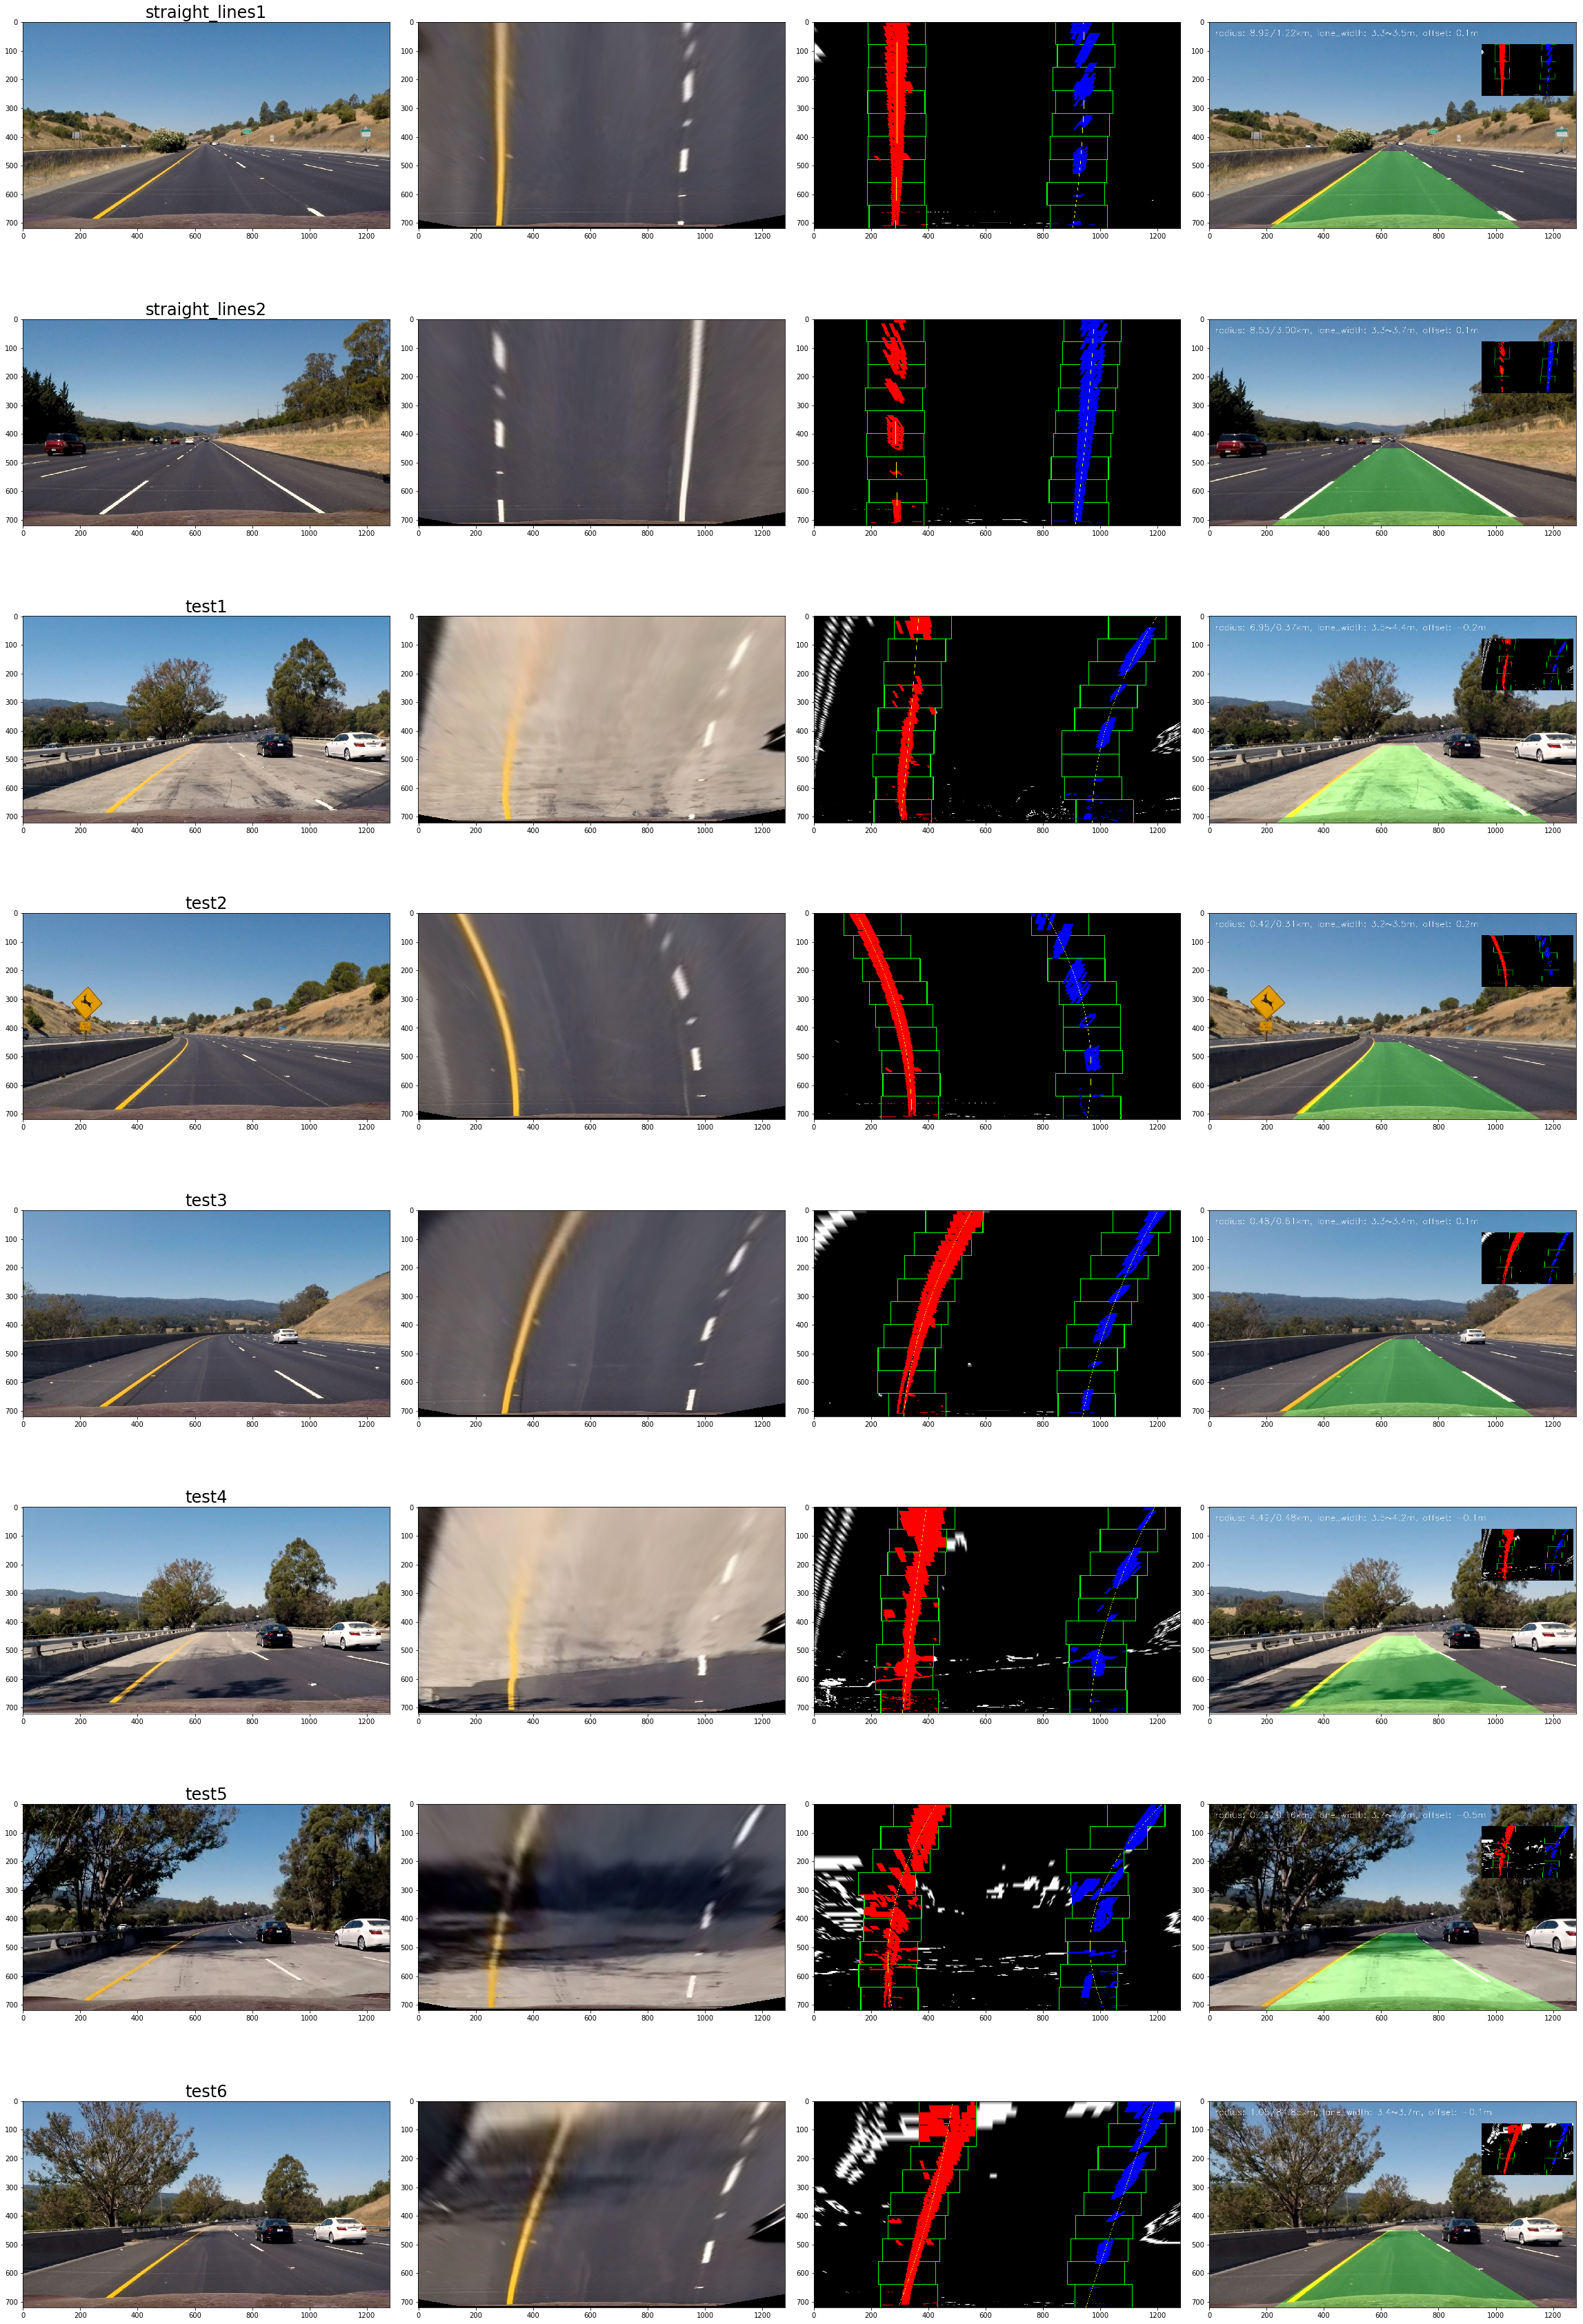

In [8]:
images = glob.glob("test_images/*.jpg")
images.sort()
fig, axes = plt.subplots(len(images), 4, figsize=(8*4, 6*len(images)))
fig.tight_layout()
pipeline = Pipeline()
for i, fname in enumerate(images):
  img = cv2.imread(fname)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  undistorted, threshold_color, warped, color_warped, binary_warped, viz_img, unwarped = pipeline.process_image(img)
  base_name = os.path.basename(fname)[:-4]
  cv2.imwrite("output_images/" + base_name +"_undistorted.jpg", cv2.cvtColor(undistorted, cv2.COLOR_RGB2BGR))
  cv2.imwrite("output_images/" + base_name +"_thresholded.jpg", cv2.cvtColor(threshold_color, cv2.COLOR_RGB2BGR))
  cv2.imwrite("output_images/" + base_name +"_warped.jpg", cv2.cvtColor(warped, cv2.COLOR_RGB2BGR))
  cv2.imwrite("output_images/" + base_name +"_viz.jpg", cv2.cvtColor(viz_img, cv2.COLOR_RGB2BGR))
  cv2.imwrite("output_images/" + base_name +"_unwarped.jpg", cv2.cvtColor(unwarped, cv2.COLOR_RGB2BGR))
  for j, out_img in enumerate([img, warped, viz_img, unwarped]):
    if len(out_img.shape) == 3:
      axes[i, j].imshow(out_img)
    else:
      axes[i, j].imshow(out_img, cmap='gray')
    axes[i, 0].set_title(base_name, fontsize=24)


In [3]:
from IPython.display import HTML
from moviepy.editor import VideoFileClip

pipeline = Pipeline()
def process_image(img):
  return pipeline.process_image(img)[-1]

videos = ["project_video.mp4", "challenge_video.mp4", "harder_challenge_video.mp4"]
for video in videos:
  clip = VideoFileClip(video)
  pipeline.reset()
  output_clip = clip.fl_image(lambda img: pipeline.process_image(img, False)[-1])
  output_video = "output_images/" + video
  %time output_clip.write_videofile(output_video, audio=False)


[MoviePy] >>>> Building video output_images/project_video.mp4
[MoviePy] Writing video output_images/project_video.mp4


100%|█████████▉| 1260/1261 [02:47<00:00,  7.76it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video.mp4 

CPU times: user 3min 54s, sys: 53.7 s, total: 4min 48s
Wall time: 2min 48s
[MoviePy] >>>> Building video output_images/challenge_video.mp4
[MoviePy] Writing video output_images/challenge_video.mp4


100%|██████████| 485/485 [01:07<00:00,  8.07it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/challenge_video.mp4 

CPU times: user 1min 34s, sys: 22.2 s, total: 1min 56s
Wall time: 1min 8s
[MoviePy] >>>> Building video output_images/harder_challenge_video.mp4
[MoviePy] Writing video output_images/harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [03:38<00:00,  6.85it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/harder_challenge_video.mp4 

CPU times: user 4min 37s, sys: 1min, total: 5min 38s
Wall time: 3min 40s


In [5]:
html = ""
for video in videos:
  html +="""
  <p>%s<video width='960' height='540' controls><source src='%s'></video></p>
  """ % (video, "output_images/" + video)
HTML(html)